(lecture07:estimating-probabilities-from-data)=
# Estimating probabilities from data - Bootstrapping

You can use the same idea we used in simulations to estimate probabilities from experiments.
So, if $I$ is the background information and $A$ is a logical proposition that is experimentally testable, then

$$
p(A|I) \approx \frac{\text{Number of times}\;A\;\text{is True under}\;I\;\text{in}\;N\;\text{experiments}}{N}.
$$

There is a catch here.
The experiments must be *independently* done.
This means that you should prepare any apparatus you are using in exactly the same way for all experiments and that no experiment should affect any other in any way.
Most of the experiments we run in a lab are independent.
However, this assumption may be wrong for data collected in the wild.

(lecture07:example-high-performance buildings)=
## Example - Estimating the probability of excessive energy use

Let's try this in practice using the high-performance building dataset.
I'm importing the libraries and loading the data below.

In [23]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
   
# The url of the file we want to download
!curl -O 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/temperature_raw.xlsx'

import numpy as np
import pandas as pd
df = pd.read_excel('temperature_raw.xlsx')
df = df.dropna(axis=0)
df.date = pd.to_datetime(df['date'], format='%Y-%m-%d')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277k  100  277k    0     0   959k      0 --:--:-- --:--:-- --:--:--  961k


The background information $I$ is as follows:

> A random household is picked on a random week during the heating season.
> The heating season is defined to be the time of the year during which the 
> weekly average of the external temperature is less than 55 degrees F.

The logical proposition $A$ is:

> The weekly HVAC energy consumption of the household exceeds 400 kWh.

First, we start by selecting the subset of the data that pertains to the heating season.

In [24]:
df_heating = df[df['t_out'] < 55]
df_heating.round(2)

,household,date,score,t_out,t_unit,hvac
0,a1,2018-01-07,100.0,4.28,66.69,246.47
1,a10,2018-01-07,100.0,4.28,66.36,5.49
2,a11,2018-01-07,58.0,4.28,71.55,402.09
3,a12,2018-01-07,64.0,4.28,73.43,211.69
4,a13,2018-01-07,100.0,4.28,63.92,0.85
...,...,...,...,...,...,...
5643,c44,2020-02-25,59.0,43.64,76.49,19.14
5644,c45,2020-02-25,87.0,43.64,71.17,30.79
5646,c47,2020-02-25,97.0,43.64,68.60,5.34
5647,c48,2020-02-25,92.0,43.64,73.43,18.04


We have 2741 such measurements.
Now we want to pick a random household on a random week.
Unfortunately, in this dataset this is not exactly equivalent to picking a row at random because there are some missing data.
So, if we wanted to be very picky we would have to find the number of weeks during which we have data from all households.
However, we won't be so picky.
The result would not be far off what we estimate by randomly picking rows.

Okay, so here is what we are going to do.
We will pick $N$ rows at random.
For each one of the rows we are going to test if the logical proposition $A$ is True.
Finally, we are going to divide the number of times $A$ is True with $N$.
Alright, let's do it.

In [25]:
# The number of rows to pick
N = 500
# Each row corresponds to an integer from 0 to 2740. Pick
# N such integers at random
rows = np.random.randint(0, df_heating.shape[0], size=N)

In [26]:
rows

array([2064, 1707, 2158, 2333,  364, 1753, 1175, 1040, 1799,   90,   64,
       2542, 1198,  151, 2146, 2537, 1999, 2517, 2435, 2260,  158, 1368,
       2687,  975, 1107,  240, 1830,  457, 2329, 2310, 1545, 1268, 1445,
        362,  543,  429,  221, 1082,  594,  612, 2600, 1961, 2446, 2508,
        254, 1148, 2590,  542,   28,   80, 1269, 1490,  573, 2029,  874,
       2187,  115, 2084, 1988, 2157, 1173,  258, 2566,  479,   43, 1298,
       1557, 1962, 2584, 2088,  221,  708,  160,  248, 1230, 1189, 2251,
       1983, 2642,  921, 2224, 2327,   62, 1624, 2727, 1321, 1400,  622,
       2706, 2614, 1587,  596, 2358,  300, 2233, 1770, 2483, 1724,  736,
       1529, 2673, 2324,  529, 1096,  685, 1611, 1594, 1936, 1890, 2420,
       1009,  358, 2567, 2683, 1362, 1695, 2632,  573, 1992, 1486,  806,
       1834,  262,  805, 1368,  108, 2395, 1193,   33,  233,  942, 2090,
       1022, 2164,  354,  929, 1400,  343, 1526, 1755, 1323,  389, 1507,
        595, 2248,   63,  566,  746, 2600, 2499,  9

Now we need to pick the rows of `df_heating` that have those indices.
We can do it like this:

In [27]:
df_heating_exp = df_heating.loc[df_heating.index[rows]]
df_heating_exp.round(2)

,household,date,score,t_out,t_unit,hvac
4805,a14,2019-11-10,72.0,40.18,72.03,6.02
3109,a3,2019-03-17,71.0,44.42,73.83,66.78
4917,b18,2019-11-24,71.0,39.33,72.77,154.92
5134,c35,2019-12-22,98.0,29.01,69.68,127.01
400,a1,2018-03-04,90.0,45.47,71.80,24.55
...,...,...,...,...,...,...
5244,c45,2020-01-05,65.0,42.50,72.08,81.80
2742,c43,2019-01-20,58.0,30.01,76.89,158.46
823,b24,2018-04-29,96.0,53.95,74.44,51.82
4816,b17,2019-11-10,86.0,40.18,69.42,185.45


Now let's evaluate the value of the logical proposition $A$ for each one of these rows.

In [28]:
df_heating_exp_A = df_heating_exp['hvac'] > 300
df_heating_exp_A

4805    False
3109    False
4917    False
5134    False
400     False
        ...  
5244    False
2742    False
823     False
4816    False
5434    False
Name: hvac, Length: 500, dtype: bool

Now, we need to count the number of times the logical proposition was `True`.
We can do this either with the function [pandas.Dataframe.value_counts()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html):

In [29]:
df_heating_exp_A_counts = df_heating_exp_A.value_counts()
df_heating_exp_A_counts

hvac
False    466
True      34
Name: count, dtype: int64

This returned both the `True` and the `False` counts.
To get just the `True` counts:

In [30]:
number_of_A_true = df_heating_exp_A_counts[True]
number_of_A_true

34

And now we can estimate the probability by dividing the number of times $A$ was `True` with the number of randomly selected rows $N$.
We get this:

In [31]:
p_A_g_I = number_of_A_true / N
print(f'p(A|I) ~= {p_A_g_I:1.2f}')

p(A|I) ~= 0.07


Nice!
This was easy.
Now, you may say why didn't you pick all rows?
I could have, and if I had a really really big number of rows I would be getting a very good estimate of the probability.
But you never know if you have enough data.
It is not like the simulated experiment where we could do as many runs as we liked.
Most of the times, we have a finite amount of data that is not good enough for an accurate estimate.
In other words, there is a bit of epistemic uncertainty in our estimate of the probability.
There is something we can do to estimate this epistemic uncertainty.
Let me show you.

First, put everything we did above in a nice function:

In [32]:
def estimate_p_A_g_I(N, df_heating):
    """Estimates the probability of A given I by randomly picking N rows
    from the data frame df_heating.
    
    Arguments:
    N             -     The number of rows to pick at random.
    df_heating    -     The data frame containing the heating data.
    
    Returns: The number of rows with A True divided by N.
    """
    rows = np.random.randint(0, df_heating.shape[0], size=N)
    df_heating_exp = df_heating.loc[df_heating.index[rows]]
    df_heating_exp_A = df_heating_exp['hvac'] > 300
    df_heating_exp_A_counts = df_heating_exp_A.value_counts()
    number_of_A_true = df_heating_exp_A_counts[True] if True in df_heating_exp_A_counts.keys() else 0
    p_A_g_I = number_of_A_true / N
    return p_A_g_I

Now we can call this function as many times as we want.
Each time we get an estimate of the probability of A given I.
It is going to be a different estimate every time because the rows are selected at random.
Here it is 10 times:

In [33]:
for i in range(10):
    p_A_g_I = estimate_p_A_g_I(500, df_heating)
    print(f'{i+1:d} estimate of p(A|I): {p_A_g_I:1.3f}')

1 estimate of p(A|I): 0.092
2 estimate of p(A|I): 0.062
3 estimate of p(A|I): 0.058
4 estimate of p(A|I): 0.072
5 estimate of p(A|I): 0.062
6 estimate of p(A|I): 0.082
7 estimate of p(A|I): 0.056
8 estimate of p(A|I): 0.050
9 estimate of p(A|I): 0.064
10 estimate of p(A|I): 0.068


Alright, every time a different number.
To get a sense of the epistemic uncertainty, we can do it many many times, say 1000 times, and plot a histogram of our estimates.
Like this:

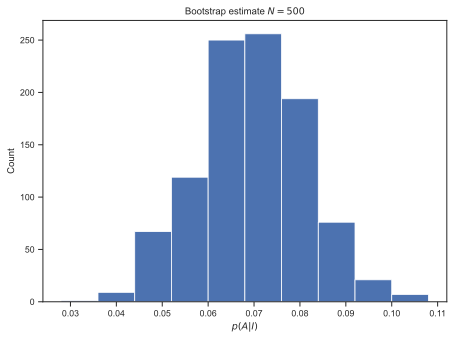

In [34]:
# A place to store the estimates
p_A_g_Is = []
# The number of rows we sample every time
N = 500
# Put 1000 estimates in there
for i in range(1000):
    p_A_g_I = estimate_p_A_g_I(N, df_heating)
    p_A_g_Is.append(p_A_g_I)
# And now do the histogram
fig, ax = make_full_width_fig()
ax.hist(p_A_g_Is)
ax.set_xlabel('$p(A|I)$')
ax.set_ylabel('Count')
ax.set_title(f'Bootstrap estimate $N = {N:d}$');
save_for_book(fig, 'ch7.fig2')

So looking at this, we can say that the $p(A|I)$ is around 7%, but it could be as low as 5% or as high as 9%. 
This way of estimating the uncertainty of statistics by resampling the data is called [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).

### Questions

+ Rerun the bootstrapping estimate of $p(A|I)$ using $N=100$ (very small). What happens to the range of possibilities?
+ Rerun the bootstrapping estimate of $p(A|I)$ using $N=1000$ (reasonable). Did the range of possibilities change compared to $N=500$?
+ Rerun the bootstrapping estimate of $p(A|I)$ using $N=2741$ (the maximum, and reasonable). What about now? How does the range look-like now? Why, didn't the uncertainty collapse completly? Hint: Think about how we sample the rows of the data frame. Is there a chance that we miss some?
+ What if you go to $N=5000$?